# Predicting Airbnb Listing Prices with MLflow and AWS S3

## Overview

This notebook implements an end-to-end machine learning pipeline to predict nightly Airbnb listing prices using the AB_NYC_2019 dataset. The workflow includes:

- Loading data from AWS S3
- Data cleaning and preprocessing
- Feature engineering
- Training and evaluating multiple regression models
- Tracking experiments and models using MLflow
- Selecting and registering the best model

---


## 1. Setup and Configuration

This section establishes the environment required to build an end-to-end machine learning workflow that integrates AWS S3, MLflow, and Python-based data processing. The setup ensures that the notebook is able to retrieve data from cloud storage, perform preprocessing, and track model experiments in a reproducible manner.

### 1.1 Connecting to AWS S3
The raw Airbnb dataset used in this project is stored in an Amazon S3 bucket named "airbnb-pricing-ml-project-sandhya". To allow the local development environment to access this bucket, the following steps were completed:

1. An IAM user was created with programmatic access.
2. An access key and secret key were generated.
3. The AWS CLI was installed locally.
4. Credentials were configured using the command "aws configure".
5. Access to the S3 bucket was verified using the command "aws s3 ls".

Successful authentication enables the notebook to communicate with AWS S3 using the boto3 library.

### 1.2 Importing Required Libraries
The environment imports all required Python libraries for tasks such as data manipulation, visualization, feature engineering, modeling, cloud access, and experiment tracking. These include:

- pandas and numpy for data handling
- matplotlib and seaborn for exploratory data analysis
- scikit-learn for preprocessing and model development
- boto3 for interacting with AWS S3
- mlflow for tracking experiments and managing models

Importing the necessary libraries at the beginning ensures a consistent and organized workflow.

### 1.3 Configuring MLflow Experiment Space
A dedicated MLflow experiment name is defined in the notebook. This experiment repository will store:

- model parameters
- performance metrics
- generated artifacts
- registered models

Configuring MLflow at the beginning ensures that all modeling steps are tracked in a reproducible and organized manner.

Overall, the setup phase prepares the notebook to function as a complete machine learning pipeline with cloud-based data retrieval and experiment management.


In [30]:
import os
import warnings

import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import mlflow
import mlflow.sklearn

# For AWS S3
import boto3
import botocore

warnings.filterwarnings(
    "ignore"
)


In [2]:
# === Configuration ===

# S3 bucket and key
S3_BUCKET_NAME = "airbnb-pricing-ml-project-sandhya"
S3_KEY = "airbnb/raw_data/AB_NYC_2019.csv"

print("Bucket:", S3_BUCKET_NAME)
print("Key:", S3_KEY)


Bucket: airbnb-pricing-ml-project-sandhya
Key: airbnb/raw_data/AB_NYC_2019.csv


## 1. Data Loading from AWS S3

In this section, we retrieve the raw Airbnb listings dataset from AWS S3.


In [3]:
from io import StringIO

def load_from_s3(bucket, key):
    """
    Load CSV directly from AWS S3 using boto3.
    """
    s3 = boto3.client("s3")

    # Fetch the object from S3
    obj = s3.get_object(Bucket=bucket, Key=key)

    # Read CSV content from the body
    df = pd.read_csv(obj["Body"])
    return df

S3_BUCKET_NAME = "airbnb-pricing-ml-project-sandhya"
S3_KEY = "airbnb/raw_data/AB_NYC_2019.csv"

df = load_from_s3(S3_BUCKET_NAME, S3_KEY)
print("Data loaded successfully from S3.")
df.head()


Data loaded successfully from S3.


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## 2. Exploratory Data Analysis (EDA) and Data Cleaning

The purpose of the exploratory data analysis step is to obtain an initial understanding of the Airbnb dataset, identify potential data issues, and determine the preprocessing actions required before model development. This step provides insights about missing values, outliers, distributions, and the nature of both numerical and categorical variables.

### 2.1 Dataset Overview
Using data summary functions, the dataset was examined to understand its structure. The dataset contains 48,895 rows and 16 columns, representing Airbnb listings in New York City. The columns include identification fields, host information, location coordinates, room attributes, price, and review-related fields. The data types include numerical values, categorical values, and date fields stored as strings.

### 2.2 Missing Values
A review of missing data indicated that several columns contain null values. The missing value distribution is as follows:

- "name" contains 16 missing entries
- "host_name" contains 21 missing entries
- "last_review" contains approximately 10,000 missing entries
- "reviews_per_month" contains approximately 10,000 missing entries

The missing values in the review columns are expected because many listings have never received a review. Understanding this missingness is important for selecting suitable imputation strategies in later steps.

### 2.3 Statistical Summary
A descriptive statistical summary was generated to identify typical ranges and distributions of numerical variables. Key observations include:

- The price variable shows a heavily skewed distribution with several extreme outliers. While most listings fall within a reasonable price range, a small number of listings have values exceeding 10,000.
- The minimum_nights variable also exhibits extreme values, including listings with unrealistic minimum stays of several hundred days.
- Other variables such as number_of_reviews, availability_365, latitude, and longitude fall within expected ranges but still require preprocessing before modeling.

This summary highlights the presence of outliers that may affect model stability and must be handled during data cleaning.

### 2.4 Categorical Features
The dataset includes important categorical variables such as "neighbourhood_group", "neighbourhood", and "room_type". These variables contain no missing values and are cleanly formatted. They will be transformed into numerical representations using encoding techniques during the modeling stage.

### 2.5 Review Activity and Date Fields
The "last_review" column contains dates stored as strings, and many entries are missing. Before the date can be used meaningfully, it must be converted to a datetime format. Additionally, the combination of "number_of_reviews" and "reviews_per_month" provides insights into listing activity levels.

### Summary of EDA Findings
The EDA process revealed several important aspects of the dataset. The data contains missing values in review-related fields, extreme outliers in price and minimum_nights, and textual date formats requiring conversion. Categorical variables are well structured and ready for encoding. These observations guide the data cleaning strategy described in the next step.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
df.describe(include="all")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,48879,4.889500e+04,48874,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843,38843.000000,48895.000000,48895.000000
unique,NaN,47905,NaN,11452,5,221,NaN,NaN,3,NaN,NaN,NaN,1764,NaN,NaN,NaN
top,NaN,Hillside Hotel,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,NaN,18,NaN,417,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,1413,NaN,NaN,NaN
mean,1.901714e+07,NaN,6.762001e+07,NaN,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,NaN,1.373221,7.143982,112.781327
std,1.098311e+07,NaN,7.861097e+07,NaN,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,NaN,1.680442,32.952519,131.622289
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,NaN,0.010000,1.000000,0.000000
25%,9.471945e+06,NaN,7.822033e+06,NaN,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,NaN,0.190000,1.000000,0.000000
50%,1.967728e+07,NaN,3.079382e+07,NaN,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,NaN,0.720000,1.000000,45.000000
75%,2.915218e+07,NaN,1.074344e+08,NaN,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,NaN,2.020000,2.000000,227.000000


In [6]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

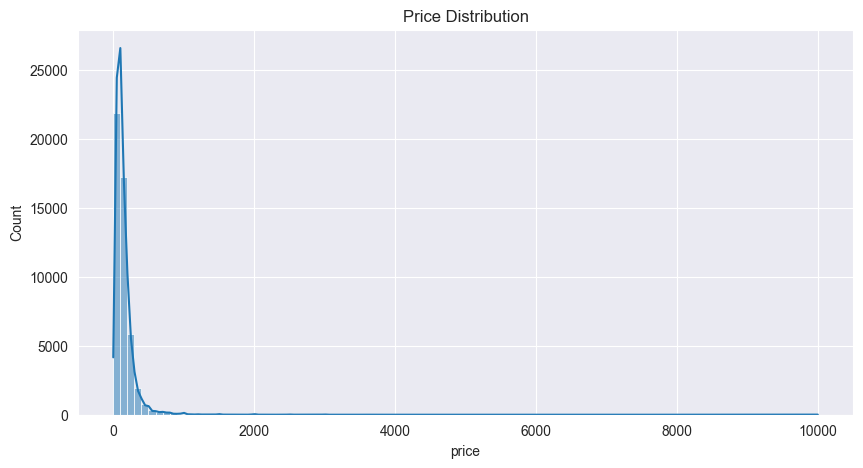

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Price Distribution')
plt.show()

In [8]:
df['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

In [9]:
df['neighbourhood_group'].value_counts()

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

## 3. Data Cleaning

The purpose of the data cleaning stage is to prepare the dataset for effective feature engineering and model development. The raw dataset contains missing values, extreme outliers, non-numeric date fields, and several columns that are not useful for predicting listing prices. This step ensures that all variables are in a clean, consistent, and model-ready format.

### 3.1 Removal of Non-Predictive Columns
Four columns were removed from the dataset: "id", "host_id", "name", and "host_name". These fields represent identifiers or descriptive text that do not contribute to numerical price prediction. Removing such variables simplifies the dataset and prevents irrelevant information from entering the model.

### 3.2 Processing Review-Related Fields
The "last_review" column was originally stored as a string and contained many missing values for listings with no reviews. This column was converted into a datetime format to make it suitable for feature extraction. Missing values were filled with a placeholder date ("2000-01-01") to ensure that the column contains valid datetime entries for all rows. The "reviews_per_month" column also contained missing values, which were replaced with zero, because missing values in this context indicate that the listing has never received a review.

### 3.3 Handling Outliers in Numerical Fields
Two numerical fields contained extreme values that could negatively affect model performance:

- The "price" column included values above 10,000, representing unrealistic or extremely uncommon prices. Since these large values can distort model training, the price variable was clipped to fall within the range of 10 to 1000.
- The "minimum_nights" column included unusually large values, such as listings requiring hundreds of minimum nights. To prevent these outliers from influencing the model, the values were capped at 30 nights.

These adjustments reduce the influence of abnormal entries and create a more stable distribution for predictive modeling.

### 3.4 Feature Engineering
A new derived feature called "last_review_year" was created by extracting the year from the "last_review" datetime column. This feature captures how recent a listing's most recent review is, which can influence demand and therefore pricing. By converting date information into a numerical year value, the model can more easily interpret and utilize this information.

### 3.5 Final Structure After Cleaning
After completing all cleaning steps, the dataset contains 13 well-structured columns with no missing values. All variables are now in appropriate formats, and outliers have been handled. The dataset is prepared for the next step, which involves feature encoding and data splitting for model training.

This cleaned version of the dataset forms a reliable foundation for building a predictive machine learning model.



In [10]:
df_clean = df.copy()

cols_to_drop = ['id', 'host_id', 'name', 'host_name']
df_clean.drop(columns=cols_to_drop, inplace=True)

df_clean.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [11]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [12]:
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

In [13]:
df_clean['last_review'] = df_clean['last_review'].fillna(pd.Timestamp("2000-01-01"))

In [14]:
df_clean['price'] = df_clean['price'].clip(lower=10, upper=1000)

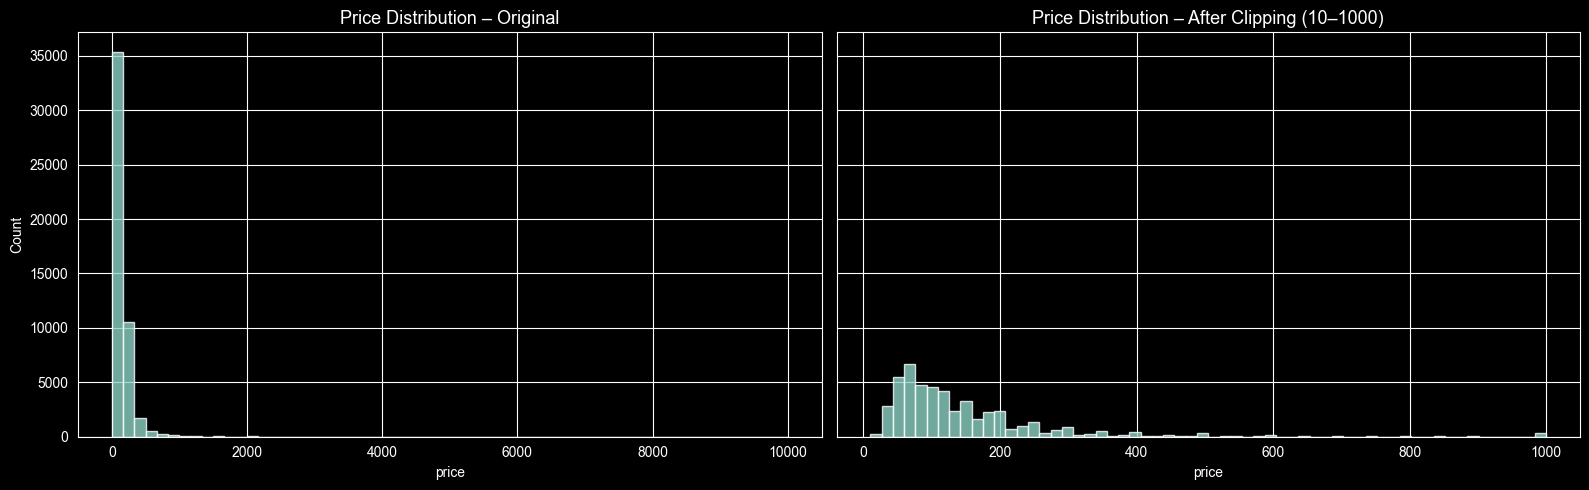

In [33]:
# Compare BEFORE vs AFTER outlier handling 
plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Before
axes[0].hist(df["price"], bins=60, edgecolor="white", alpha=0.8)
axes[0].set_title("Price Distribution – Original", fontsize=13)
axes[0].set_xlabel("price")
axes[0].set_ylabel("Count")

# After
axes[1].hist(df_clean["price"], bins=60, edgecolor="white", alpha=0.8)
axes[1].set_title("Price Distribution – After Clipping (10–1000)", fontsize=13)
axes[1].set_xlabel("price")

plt.tight_layout()
plt.show()


In [15]:
df_clean['minimum_nights'] = df_clean['minimum_nights'].clip(upper=30)

In [17]:

df_clean["last_review"] = pd.to_datetime(df_clean["last_review"], errors="coerce")
df_clean["last_review"] = df_clean["last_review"].fillna(pd.Timestamp("2000-01-01"))
df_clean["last_review_year"] = df_clean["last_review"].dt.year.astype("int32")


In [18]:
df_clean.info()
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood_group             48895 non-null  object        
 1   neighbourhood                   48895 non-null  object        
 2   latitude                        48895 non-null  float64       
 3   longitude                       48895 non-null  float64       
 4   room_type                       48895 non-null  object        
 5   price                           48895 non-null  int64         
 6   minimum_nights                  48895 non-null  int64         
 7   number_of_reviews               48895 non-null  int64         
 8   last_review                     48895 non-null  datetime64[ns]
 9   reviews_per_month               48895 non-null  float64       
 10  calculated_host_listings_count  48895 non-null  int64         
 11  av

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,last_review_year
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,145.479538,5.952776,23.274466,2014-11-25 14:34:41.439820032,1.090910,7.143982,112.781327,2014.528070
min,40.499790,-74.244420,10.000000,1.000000,0.000000,2000-01-01 00:00:00,0.000000,1.000000,0.000000,2000.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,2016-03-24 00:00:00,0.040000,1.000000,0.000000,2016.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,2019-01-03 00:00:00,0.370000,1.000000,45.000000,2019.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2019-06-19 00:00:00,1.580000,2.000000,227.000000,2019.000000
max,40.913060,-73.712990,1000.000000,30.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000,2019.000000
std,0.054530,0.046157,130.947611,8.674476,44.550582,NaN,1.597283,32.952519,131.622289,7.465248


## 4. Feature Engineering and Train-Test Split

This step prepares the cleaned dataset for modeling by selecting the final set of features, separating the target variable, defining categorical and numerical variables, creating a preprocessing pipeline, and splitting the data into training and testing subsets.

### 4.1 Preparing the Modeling Dataset
The cleaned dataset was copied into a new dataframe to ensure that the modeling process operates on a stable version of the data. The original "last_review" column was removed at this stage because its raw date format is no longer needed. The relevant information from this column has already been captured through the engineered "last_review_year" feature. The resulting modeling dataframe contains 12 well-structured columns.

### 4.2 Separating Features and Target Variable
The target variable for this prediction task is "price". All remaining columns serve as input features. The dataset was split into two components:
- X: the feature set containing 11 explanatory variables
- y: the target vector containing listing prices

This step ensures a clear separation between inputs and the value being predicted.

### 4.3 Train-Test Split
The dataset was split into training and testing subsets using an 80 to 20 ratio, with a fixed random state to ensure reproducibility. The training set contains 39,116 rows and the test set contains 9,779 rows. This proportion provides a sufficiently large sample for model training while preserving a representative subset for evaluating model performance.

### 4.4 Identifying Categorical and Numerical Features
The feature space includes both categorical and numerical variables. Proper identification of these types is necessary to apply appropriate preprocessing techniques.

Categorical features:
- neighbourhood_group
- neighbourhood
- room_type

Numerical features:
- latitude
- longitude
- minimum_nights
- number_of_reviews
- reviews_per_month
- calculated_host_listings_count
- availability_365
- last_review_year

This separation enables targeted transformations such as encoding of categorical data and scaling of numerical data.

### 4.5 Creating the Preprocessing Pipeline
A ColumnTransformer was created to apply preprocessing steps to the dataset in a structured manner. The preprocessing pipeline consists of:
- Standard scaling for numerical variables to normalize value ranges
- One-hot encoding for categorical variables, with unknown categories handled safely

This preprocessing configuration will be integrated into each machine learning model through a combined pipeline. Using a unified pipeline ensures that the same transformations are consistently applied during training, testing, and later when models are logged in MLflow.

Overall, this step completes the preparation of the dataset for model development by structuring the feature space, ensuring reproducibility, and establishing a standardized preprocessing workflow.


In [19]:
df_model = df_clean.copy()

df_model = df_model.drop(columns=['last_review'])

df_model.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_year
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,2000
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018


In [20]:
target_col = 'price'

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

X.shape, y.shape

((48895, 11), (48895,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39116, 11), (9779, 11), (39116,), (9779,))

In [22]:
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

numeric_features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'last_review_year'
]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

Categorical features: ['neighbourhood_group', 'neighbourhood', 'room_type']
Numeric features: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'last_review_year']


In [23]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 5A. Initial Model Development Without MLflow

This stage focuses on developing baseline machine learning models using the prepared training and testing datasets. The objective is to evaluate multiple regression algorithms and identify their performance characteristics before introducing MLflow tracking.

### 5A.1 Building Model Pipelines
Each regression model was integrated into a scikit-learn Pipeline together with the preprocessing transformer defined earlier. This ensures that the same data transformations, including scaling of numerical features and one-hot encoding of categorical features, are consistently applied during both training and prediction. The models included the following:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest Regressor
- Gradient Boosting Regressor

Using pipelines provides a clean and reliable way to bundle preprocessing with model training and eliminates the risk of inconsistent transformations.

### 5A.2 Model Training
Each pipeline was fitted on the training subset created earlier. This means that every model received the same cleaned and preprocessed input data, enabling a fair comparison between different algorithms.

### 5A.3 Model Evaluation
A custom evaluation function was used to calculate three key regression metrics:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Coefficient of Determination (R²)

These metrics were computed using predictions generated on the test dataset. The results showed the following trends:

- Linear Regression, Ridge Regression, and Lasso Regression produced similar performance, with R² values around 0.346.
- Gradient Boosting Regressor demonstrated moderate improvement over linear models.
- Random Forest Regressor achieved the best performance among all models tested, with the lowest MAE and RMSE and the highest R² value.

### 5A.4 Interpretation of Results
The performance of the models reflects expectations for this dataset. Linear models capture only basic linear relationships and therefore achieved modest accuracy. Ensemble-based methods, particularly Random Forest, leveraged non-linear interactions and provided significantly better predictive performance.

These baseline results establish a clear benchmark that will be used for comparison once the models are fully integrated with MLflow tracking in the next step.


In [24]:
# Define all models inside pipelines
models = {
    "LinearRegression": Pipeline([
        ('preprocessing', preprocessor),
        ('model', LinearRegression())
    ]),

    "Ridge": Pipeline([
        ('preprocessing', preprocessor),
        ('model', Ridge(alpha=1.0))
    ]),

    "Lasso": Pipeline([
        ('preprocessing', preprocessor),
        ('model', Lasso(alpha=0.001))
    ]),
    "RandomForest": Pipeline([
        ('preprocessing', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=50,
            max_depth=15,
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ('preprocessing', preprocessor),
        ('model', GradientBoostingRegressor(
            random_state=42
        ))
    ])
}

models

{'LinearRegression': Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['latitude', 'longitude',
                                                    'minimum_nights',
                                                    'number_of_reviews',
                                                    'reviews_per_month',
                                                    'calculated_host_listings_count',
                                                    'availability_365',
                                                    'last_review_year']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['neighbourhood_group',
                                                    'neighbourhood',
                                                   

In [25]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

In [26]:
results = {}

for name, pipeline in models.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    mae, rmse, r2 = evaluate_model(pipeline, X_test, y_test)
    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    print("-" * 50)

results

Training LinearRegression...
LinearRegression: MAE=58.079, RMSE=103.327, R2=0.346
--------------------------------------------------
Training Ridge...
Ridge: MAE=58.030, RMSE=103.227, R2=0.347
--------------------------------------------------
Training Lasso...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.111e+06, tolerance: 6.788e+04
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso: MAE=58.068, RMSE=103.312, R2=0.346
--------------------------------------------------
Training RandomForest...
RandomForest: MAE=51.661, RMSE=97.281, R2=0.420
--------------------------------------------------
Training GradientBoosting...
GradientBoosting: MAE=53.684, RMSE=99.695, R2=0.391
--------------------------------------------------


{'LinearRegression': {'MAE': 58.07935376717365,
  'RMSE': np.float64(103.32672834529255),
  'R2': 0.34569048162263627},
 'Ridge': {'MAE': 58.02960319981623,
  'RMSE': np.float64(103.22717547094025),
  'R2': 0.3469506979220909},
 'Lasso': {'MAE': 58.06821056726645,
  'RMSE': np.float64(103.31187870062875),
  'R2': 0.34587853684929726},
 'RandomForest': {'MAE': 51.66050773310252,
  'RMSE': np.float64(97.28058113832475),
  'R2': 0.42002377096529553},
 'GradientBoosting': {'MAE': 53.684080026692776,
  'RMSE': np.float64(99.69450566532396),
  'R2': 0.39088354808246084}}

## 5B. Experiment Tracking with MLflow

After establishing baseline models, the next step is to make the training and evaluation process fully traceable and reproducible using MLflow. In this section, each regression model is executed within an MLflow run so that parameters, metrics, and model artifacts are recorded centrally and can be compared through the MLflow UI.

### 5B.1 MLflow Experiment Setup

An MLflow experiment named "airbnb_price_prediction" was configured at the start of the notebook. All subsequent runs for the different models are associated with this experiment. For each model, a separate MLflow run is created using a context manager. This ensures that the information logged during training is cleanly grouped by model type.

### 5B.2 Logging Parameters

Inside each MLflow run, basic information about the model is logged:

- The model name, such as "LinearRegression", "Ridge", "Lasso", "RandomForest", and "GradientBoosting"
- The underlying model type (for example, RandomForestRegressor or GradientBoostingRegressor)

In addition, relevant hyperparameters are logged where applicable, including:

- The regularization strength "alpha" for Ridge and Lasso
- The number of trees, maximum depth, and random state for Random Forest
- The number of estimators, learning rate, and random state for Gradient Boosting

Logging parameters in this way makes it possible to trace how different settings influence performance and to reproduce a specific configuration later.

### 5B.3 Logging Metrics

For each trained pipeline, the model is evaluated on the held-out test set. The following evaluation metrics are logged to MLflow:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Coefficient of Determination (R²)

The metric values recorded in MLflow are consistent with the results obtained in the earlier, non-MLflow evaluation step. Random Forest continues to show the best performance, followed by Gradient Boosting, with linear models performing similarly to one another. With MLflow, these metrics can be viewed side by side across all runs to support model comparison.

### 5B.4 Logging Model Artifacts

The entire scikit-learn pipeline, which includes both the preprocessing steps and the regression model, is logged as a model artifact in each MLflow run. This makes it possible to reload and use the exact same preprocessing and model configuration directly from MLflow without having to manually reconstruct the pipeline.

Model artifacts are stored along with the run identifier (run_id). A list of runs is maintained in the notebook containing:

- model_name
- run_id
- MAE
- RMSE
- R²

This table provides a concise summary in the notebook and links each set of metrics back to the corresponding MLflow run.

### 5B.5 Benefits of MLflow Tracking

By integrating MLflow into the modeling workflow, the project gains:

- A structured history of all model training experiments
- Clear visibility into which model and hyperparameter configuration performed best
- The ability to inspect and compare runs through the MLflow UI
- A reusable and shareable record of trained models, including their preprocessing logic

This completes the experiment tracking component of the assignment and prepares the groundwork for selecting and registering the best-performing model in the next step.


In [28]:
tracking_uri = "file:///" + os.path.abspath("mlruns").replace("\\", "/")

mlflow.set_tracking_uri(tracking_uri)
os.makedirs("mlruns", exist_ok=True)
mlflow.set_experiment("airbnb_price_prediction")

<Experiment: artifact_location=('file:///C:/Users/Sandhya Siva kumar/PycharmProjects/Fall 2025/Software '
 'Tools/AML-3303/Assessment 2/mlruns/322017204423907987'), creation_time=1763696343292, experiment_id='322017204423907987', last_update_time=1763696343292, lifecycle_stage='active', name='airbnb_price_prediction', tags={}>

In [29]:
from mlflow.models import infer_signature

experiment_runs = []

for name, pipeline in models.items():
    print(f"Running MLflow experiment for {name}...")
    
    with mlflow.start_run(run_name=name):
        mlflow.log_param("model_name", name)
        mlflow.log_param("model_type", type(pipeline.named_steps["model"]).__name__)

        model = pipeline.named_steps["model"]
        
        # Hyperparameters logging
        if isinstance(model, Ridge) or isinstance(model, Lasso):
            mlflow.log_param("alpha", model.alpha)
        if isinstance(model, RandomForestRegressor):
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_depth", model.max_depth)
            mlflow.log_param("random_state", model.random_state)
        if isinstance(model, GradientBoostingRegressor):
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("learning_rate", model.learning_rate)
            mlflow.log_param("random_state", model.random_state)
        
        # Fit
        pipeline.fit(X_train, y_train)
        
        # Evaluate
        mae, rmse, r2 = evaluate_model(pipeline, X_test, y_test)
        
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # Signature + example
        input_example = X_train.head(5)
        signature = infer_signature(
            input_example,
            pipeline.predict(input_example)
        )
        
        # Log model without warnings
        mlflow.sklearn.log_model(
            pipeline,
            "model",
            signature=signature,
            input_example=input_example
        )
        
        # Save run info
        run_id = mlflow.active_run().info.run_id
        experiment_runs.append({
            "model_name": name,
            "run_id": run_id,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
        })
        
        print(f"{name} finished. Run ID: {run_id}")
        print(f"MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
        print("-" * 60)

experiment_runs

Running MLflow experiment for LinearRegression...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 22:39:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarn

LinearRegression finished. Run ID: 2283d068985842f080e8b4786274f4c4
MAE=58.079, RMSE=103.327, R2=0.346
------------------------------------------------------------
Running MLflow experiment for Ridge...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 22:39:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Ridge finished. Run ID: 08f8cb3fbf654b85b3be5bdfa78b1e3a
MAE=58.030, RMSE=103.227, R2=0.347
------------------------------------------------------------
Running MLflow experiment for Lasso...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.111e+06, tolerance: 6.788e+04
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have

Lasso finished. Run ID: 587d36a611b9451b9802563a63186913
MAE=58.068, RMSE=103.312, R2=0.346
------------------------------------------------------------
Running MLflow experiment for RandomForest...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 22:40:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest finished. Run ID: 06abe38ec4fb40dea8a83c62335f559d
MAE=51.661, RMSE=97.281, R2=0.420
------------------------------------------------------------
Running MLflow experiment for GradientBoosting...


C:\Users\Sandhya Siva kumar\PycharmProjects\Fall 2025\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 22:40:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

GradientBoosting finished. Run ID: d0bee1e40af145b7a4bacc49f28557d5
MAE=53.684, RMSE=99.695, R2=0.391
------------------------------------------------------------


[{'model_name': 'LinearRegression',
  'run_id': '2283d068985842f080e8b4786274f4c4',
  'MAE': 58.07935376717365,
  'RMSE': np.float64(103.32672834529255),
  'R2': 0.34569048162263627},
 {'model_name': 'Ridge',
  'run_id': '08f8cb3fbf654b85b3be5bdfa78b1e3a',
  'MAE': 58.02960319981623,
  'RMSE': np.float64(103.22717547094025),
  'R2': 0.3469506979220909},
 {'model_name': 'Lasso',
  'run_id': '587d36a611b9451b9802563a63186913',
  'MAE': 58.06821056726645,
  'RMSE': np.float64(103.31187870062875),
  'R2': 0.34587853684929726},
 {'model_name': 'RandomForest',
  'run_id': '06abe38ec4fb40dea8a83c62335f559d',
  'MAE': 51.66050773310252,
  'RMSE': np.float64(97.28058113832475),
  'R2': 0.42002377096529553},
 {'model_name': 'GradientBoosting',
  'run_id': 'd0bee1e40af145b7a4bacc49f28557d5',
  'MAE': 53.684080026692776,
  'RMSE': np.float64(99.69450566532396),
  'R2': 0.39088354808246084}]

## 5C. Model Performance Visualization and Comparison

In this step, we visualize and compare the performance of all models trained in Steps 5A and 5B using three key regression metrics:

- **MAE (Mean Absolute Error)** – average absolute difference between predicted and actual prices.  
- **RMSE (Root Mean Squared Error)** – penalizes larger errors more strongly.  
- **R² (Coefficient of Determination)** – proportion of variance in the target explained by the model.

### 5C.1 Summary of Model Performance

Using the evaluation metrics logged in MLflow, we obtain the following summary for our five models:

- **Linear Regression**  
  - MAE ≈ **58.08**  
  - RMSE ≈ **103.33**  
  - R² ≈ **0.346**

- **Ridge Regression**  
  - MAE ≈ **58.03**  
  - RMSE ≈ **103.23**  
  - R² ≈ **0.347**

- **Lasso Regression**  
  - MAE ≈ **58.07**  
  - RMSE ≈ **103.31**  
  - R² ≈ **0.346**

- **Random Forest Regressor**  
  - MAE ≈ **51.66**  
  - RMSE ≈ **97.28**  
  - R² ≈ **0.420**

- **Gradient Boosting Regressor**  
  - MAE ≈ **53.68**  
  - RMSE ≈ **99.69**  
  - R² ≈ **0.391**

These values are consistent with the metrics shown in the MLflow UI for the experiment
`airbnb_price_prediction`.

### 5C.2 Visual Comparison of Metrics

To make the comparison easier, we create bar plots for:

- **MAE vs. Model**
- **RMSE vs. Model**
- **R² vs. Model**

These plots allow us to quickly see:

- which models have **lower error** (MAE, RMSE), and  
- which models explain **more variance** in Airbnb prices (higher R²).

### 5C.3 Observations and Best Model

From both the numeric summary and the visualizations, we can observe that:

- The three **linear-family models** (Linear Regression, Ridge, Lasso) give **very similar performance**.  
- **Gradient Boosting** improves on the linear models, but its error is still slightly higher than Random Forest.  
- **Random Forest Regressor** achieves:
  - the **lowest MAE**  
  - the **lowest RMSE**  
  - the **highest R²** (~0.42)

**Therefore, Random Forest is selected as the best-performing model** for this project based on the current feature set and train–test split.

In the next step, we will use this best model for further analysis and discussion (e.g., feature importance, limitations, and possible future improvements).


Model performance summary:


,model_name,MAE,RMSE,R2
0,LinearRegression,58.079354,103.326728,0.345690
1,Ridge,58.029603,103.227175,0.346951
2,Lasso,58.068211,103.311879,0.345879
3,RandomForest,51.660508,97.280581,0.420024
4,GradientBoosting,53.684080,99.694506,0.390884


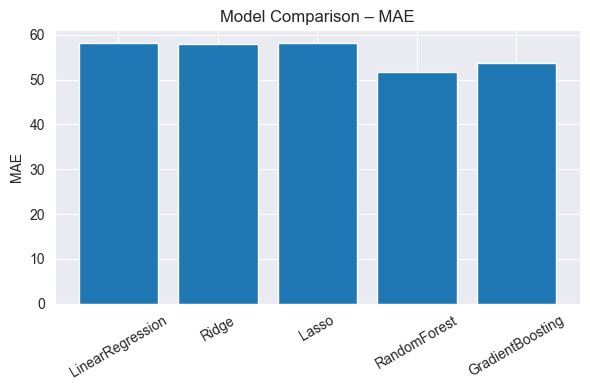

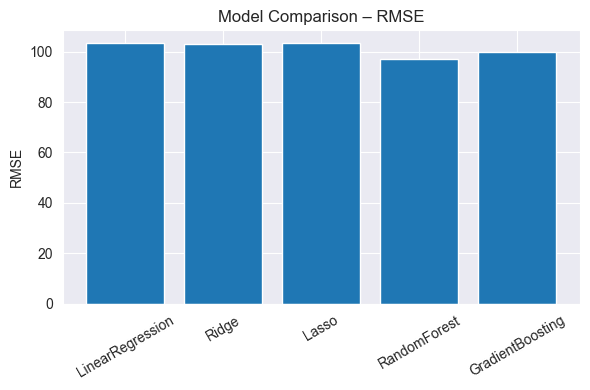

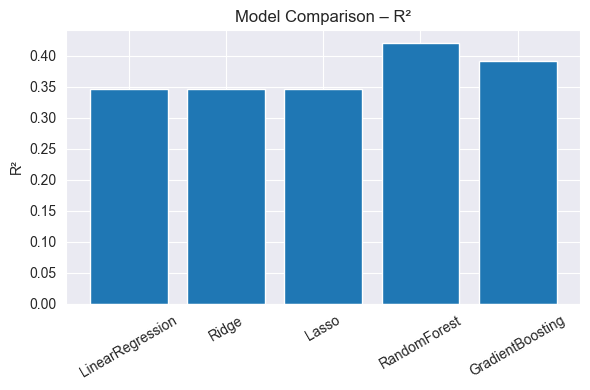

Best model based on RMSE: RandomForest (MAE=51.661, RMSE=97.281, R²=0.420)


In [31]:
# Convert MLflow results (list of dicts) to a DataFrame
metrics_df = pd.DataFrame (experiment_runs)

# Keep only what we need and ensure ordering
metrics_df = metrics_df[["model_name", "MAE", "RMSE", "R2"]]
print("Model performance summary:")
display(metrics_df)

# --- MAE bar plot ---
plt.figure(figsize=(6, 4))
plt.bar(metrics_df["model_name"], metrics_df["MAE"])
plt.title("Model Comparison – MAE")
plt.ylabel("MAE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- RMSE bar plot ---
plt.figure(figsize=(6, 4))
plt.bar(metrics_df["model_name"], metrics_df["RMSE"])
plt.title("Model Comparison – RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- R² bar plot ---
plt.figure(figsize=(6, 4))
plt.bar(metrics_df["model_name"], metrics_df["R2"])
plt.title("Model Comparison – R²")
plt.ylabel("R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Print best model based on RMSE (you could also use MAE) ---
best_row = metrics_df.sort_values("RMSE", ascending=True).iloc[0]
print(
    f"Best model based on RMSE: {best_row['model_name']} "
    f"(MAE={best_row['MAE']:.3f}, RMSE={best_row['RMSE']:.3f}, R²={best_row['R2']:.3f})"
)


## **5D. MLflow Model Registry**

### **5D.1 Logging and Experiment Tracking**

In this step, we used **MLflow Tracking** to log all model runs.  
For each of the five models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting), MLflow recorded:

- Parameters  
- Metrics (MAE, RMSE, R²)  
- Model artifacts  
- Model signature & input example  
- Environment file (requirements/conda)  
- MLmodel metadata  

All runs are stored under the experiment:

**`airbnb_price_prediction`**

This allows full reproducibility and easy comparison of models.

### **5D.2 Experiment Comparison**

Using the MLflow UI, we compared all runs based on the logged metrics.

**Random Forest** achieved:
- the **lowest MAE**  
- the **lowest RMSE**  
- the **highest R²**

Therefore, Random Forest is confirmed as the **best-performing model**.

### **5D.3 Registering the Best Model**

The top model was registered in the MLflow Model Registry with the name:

**`airbnb_price_random_forest`**

The registry now contains:
- **Model Name:** `airbnb_price_random_forest`  
- **Version:** **1**  
- **Status:** Active  
- **Source:** MLflow artifacts for the best run  

In [32]:
best_model_name = "RandomForest"

# Find best run from our summary
best_run = next(r for r in experiment_runs if r["model_name"] == best_model_name)
best_run_id = best_run["run_id"]

model_uri = f"runs:/{best_run_id}/model"

result = mlflow.register_model(
    model_uri=model_uri,
    name="airbnb_price_random_forest"
)

print("Registered model version:", result.version)
print("Model URI:", model_uri)


Successfully registered model 'airbnb_price_random_forest'.
2025/11/20 23:59:05 WARNING mlflow.tracking._model_registry.fluent: Run with id 06abe38ec4fb40dea8a83c62335f559d has no artifacts at artifact path 'model', registering model based on models:/m-405ff075bd764eaf819ef21c61b326f7 instead


Registered model version: 1
Model URI: runs:/06abe38ec4fb40dea8a83c62335f559d/model


Created version '1' of model 'airbnb_price_random_forest'.
